## eCommerce Fraud Detection
**Laura Roman** <br>
**April 2019**

### Summary 

**The objective of this analysis are to create a fraud-detection algorithm to flag a transition as fraudulent or not based on a single transaction.**

Some specific points to discuss are: <br>
**1. For each user, determine their country based on the numeric IP address**<br>
This is done in Step ii. Load the Data, using a conditional .loc function.
<br>

**2. Identify & explain evaluation metrics did you use to select a model and why:** <br>
RandomForest Classifier as the best model of those tried, which I evualated based on precision and recall (using the f1-score, which balances these two metrics) due to the high cost associate with false negatives (a fraudulent transaction flagged as legitimate).
Precision was 69% and recall was 65% (a decrease from 99%, 98% respectly once model was running on a new undersampling of the data, thus calling for additinal validation and tuning). 
    
**3. Outline use of this model to detect fraud in real-time** <br>
Once the data transformation and modeling code are summarized in a script, this model could to run on a new set of data or one transactions to determine if it fraudulent or not. 


#### Analysis Steps:

**Step ii.** <br>
Load Data and map countries to ip-addresses.

**Step 1:**
The first step is to explore the data provided: <br>
Fraud_Data and ip_address. Fraud_Data contains information individual transactions for the time period of 1 month (May 2018 that are classified as fraudulent (with a “1”) or not fraudulent (with a “0”). The data spans sign up time May 1, 2015 - August 18, 2015 (3.5 months) and purchase time May 1, 2015 - December 16, 2015 (7.5 months). 
Ip Address data provides ranges of ip-addresses that correspond to each country.<br>

**Some Observations:**
1. Nearly all of the fraudulent transactions had a signup date of May 1, 2015 and transaction date of May 1, 2015.
2. We have unbalanced classes - only 10%  of the transactions are fraudulent; if we do not correct for this, the model will tend to select the majority class (“0” for not fraudulent)
3. Age has a similar distribution across fraudulent/non-fraudulent transactions.
4. While the United States has the highest count of total fraudulent transactions, it also has the highest sample size of transactions (resulting in a fraudulent transaction raito of 9.5%);
5. Ratio of Fraud: Total Transactions:
    - Turkmenistan has the highest fraudulent/total transation ratio, but we only have one transaction to observe; <br>
   The next three are:
        - Namibia	(10/23) or 43%
        - Sri Lanka	(13/31) or 41%
        - Luxembourg (28/72) or 39%


**Step 2:** Data is transformed into numeric values and removed NaNs from countries (since some ip address did not map to a country in the ip address data set), so that it can be used in classification models.
<br>
Since our data has unbalanced classes, I under sample the majority class to balance the classes (so that the model is not biases towards choosing "0" for not fraud.


**Step 3:**
Classification models I explored:

1. RandomForest Classifier <br>
2. KNN
3. AdaBoost
4. Niave Bayes
5. Bagged Decision Tree


**Step 4:**
Evaluate models using precision, recall and f1-score (which balances precision and recall); <br>
Oberserve True Negatives, True Positives, False Negatives and False Positives in confusion matrices <br>

**Step 5:** 
Outline next steps

#### Table of Contents

[Summary](#Summary) <br>
[Step i: Import sklearn and plotting libraries](#Step-i:-Import-sklearn-and-plotting-libraries) <br>
[Step ii: Load the Data](#Step-ii:-Load-the-Data) <br>
[Step 1: Data Exploration](#Step-1:-Data-Exploration) <br>
[Step 2: Data Transforamtion](#Step-2:-Data-Transformation) <br>
[Step 3: Modeling](#Step-3:-Modeling) <br>
[Step 4: Model Evaluation](#Step-4:-Model-Evaluation) <br>
[Step 5: Next Steps](#Step-5:-Next-Steps) <br>

### Step i: Import necessary pandas, sklearn & plotting libraries

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import svm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score,make_scorer,confusion_matrix
 
import timeit

%matplotlib inline
sns.set_style("dark")

### Step ii: Load the Data

In [4]:
ip = pd.read_csv('../data/IpAddress_to_Country.csv')
fraud = pd.read_csv('../data/Fraud_Data.csv')

In [5]:
ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [6]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


**Map Countries to ip-addresses**

The following function uses .loc to identify the row in the ip address data containing the values that bound the ip address from the transaction data, and selects the corresponding country.

In [7]:
#Define a function
def country_map(ip_ad):
    countries=ip.loc[(ip['upper_bound_ip_address'] >= ip_ad) & (ip['lower_bound_ip_address'] <= ip_ad),'country'].values
    #Account for nulls
    if len(countries)==0:
        return np.nan
    return countries[0]


In [9]:
#Warning: this takes  time to run
fraud['country'] = fraud['ip_address'].apply(lambda row: country_map(row))

In [ ]:
fraud.head()

In [10]:
#Save resulting file before ordinalizing
fraud_with_country = fraud.to_csv('../data/fraud_w_country.csv')

[Back to Table of Contents](#Table-of-Contents)

### Step 1: Data Exploration

In [10]:
fraud.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class'],
      dtype='object')

In [11]:
fraud.isna().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [12]:
fraud.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

In [13]:
fraud.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [14]:
len(fraud.index.unique())

151112

In [15]:
device_pv = pd.DataFrame(fraud[['device_id','purchase_value']].groupby('device_id').sum()
                         .sort_values(by='purchase_value',ascending=False))
device_pv.reset_index(inplace=True)

In [16]:
device_pv.head()

,device_id,purchase_value
0,KPAAACGRQWYIK,1458
1,UOMHJMHDVTLAS,1376
2,EQYVNEGOFLAWK,1369
3,KHHAMKJCMODJA,1320
4,TZSHXHDMKLRYJ,1288


/Users/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


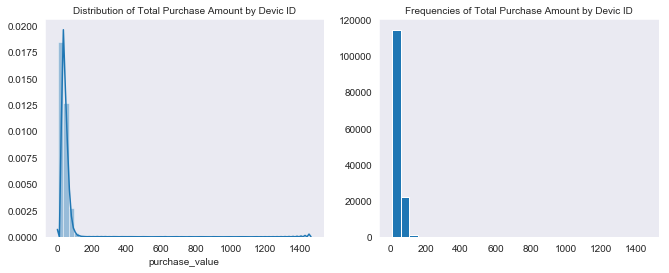

In [17]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(11,4))
sns.distplot(device_pv['purchase_value'],ax=ax1)
ax2.hist(device_pv['purchase_value'],bins=30)
ax1.set_title("Distribution of Total Purchase Amount by Devic ID",fontsize=10)
ax2.set_title("Frequencies of Total Purchase Amount by Devic ID",fontsize=10);

Define a function to visually inspect unique values in features:

In [18]:
def create_eda_bar(col):
    plt.figure(figsize=(6,4))
    ax = sns.barplot(fraud[col].unique(),fraud[col].value_counts())
    for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+1000),fontsize=12)
    ax.set_title("Unqiue Values and Counts of " + col[0].upper() + col[1:],fontsize=14)

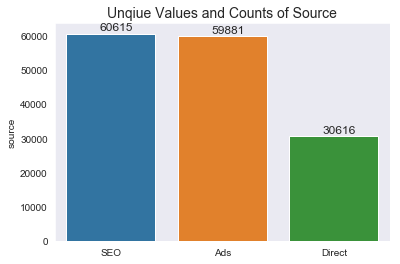

In [19]:
create_eda_bar('source')

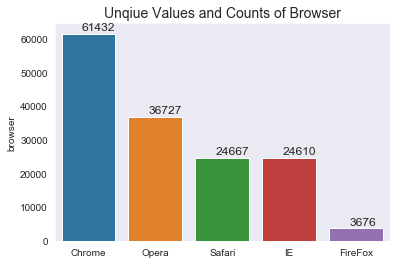

In [20]:
create_eda_bar('browser')

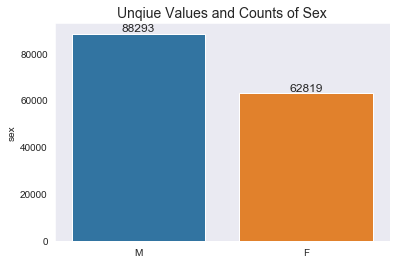

In [21]:
create_eda_bar('sex')

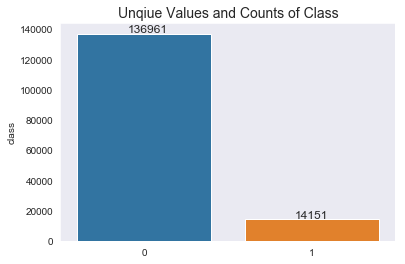

In [22]:
create_eda_bar('class')

In [23]:
fraud['class'].value_counts(normalize=True)


0    0.906354
1    0.093646
Name: class, dtype: float64

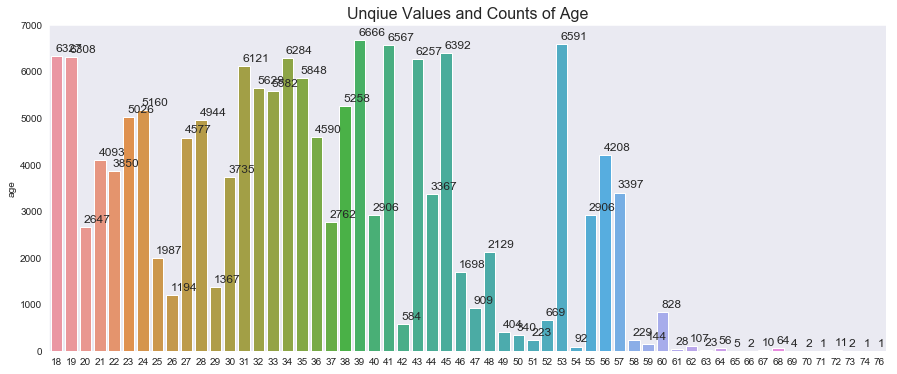

In [24]:
plt.figure(figsize=(15,6))
ax = sns.barplot(fraud['age'].unique(),fraud['age'].value_counts())
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+100),fontsize=12)
ax.set_title("Unqiue Values and Counts of Age",fontsize=16);

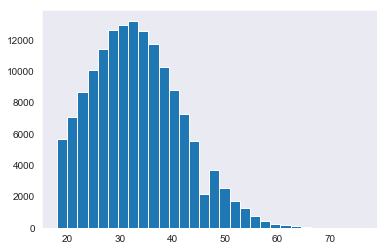

In [25]:
plt.hist(fraud['age'],bins=30);

In [26]:
#Average purchase_value for each
fraud[['purchase_value','class']].groupby('class').mean()

,purchase_value
class,
0,36.929418
1,36.993004


Plot the Relationship between Signup time, Purchase Time and whether the transaction was fraudulent or not

In [27]:
#Convert signup_time and purchase_time to datetime,
fraud['signup_time'] = pd.to_datetime(fraud['signup_time'])
fraud['purchase_time'] = pd.to_datetime(fraud['purchase_time'])

In [28]:
fraud['signup_time'].min(), fraud['signup_time'].max()

(Timestamp('2015-01-01 00:00:42'), Timestamp('2015-08-18 04:40:29'))

In [29]:
fraud['purchase_time'].min(), fraud['purchase_time'].max()

(Timestamp('2015-01-01 00:00:44'), Timestamp('2015-12-16 02:56:05'))

/Users/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


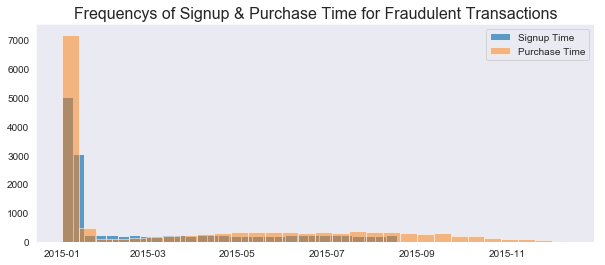

In [30]:
plt.figure(figsize=(10,4))
plt.hist(fraud['signup_time'][fraud['class']==1],bins=30,alpha=0.7, label="Signup Time")
plt.hist(fraud['purchase_time'][fraud['class']==1],bins=30,alpha=0.5,label="Purchase Time")
plt.title("Frequencys of Signup & Purchase Time for Fraudulent Transactions",fontsize=16)
plt.legend();

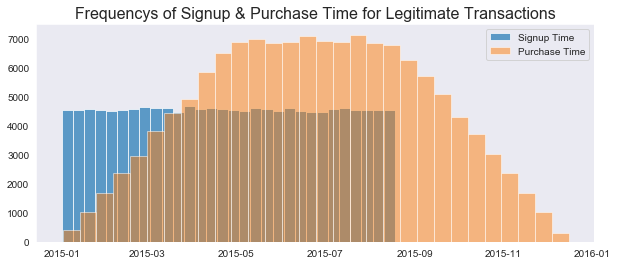

In [31]:
plt.figure(figsize=(10,4))
plt.hist(fraud['signup_time'][fraud['class']==0],bins=30,alpha=0.7, label="Signup Time")
plt.hist(fraud['purchase_time'][fraud['class']==0],bins=30,alpha=0.5,label="Purchase Time")
plt.title("Frequencys of Signup & Purchase Time for Legitimate Transactions",fontsize=16)
plt.legend();

Define a function to plot categories of fraudulent vs legitimate transactions

In [32]:
def fraud_no_fraud_chart(col):
    df1 = pd.DataFrame(fraud[fraud['class']==1].groupby(col).count())
    df0 = pd.DataFrame(fraud[fraud['class']==0].groupby(col).count())
    
    fig, ax = plt.subplots(1,2,figsize=(14,5),sharey=True)
    
    sns.barplot(df1.index.unique(),df1['class'],ax=ax[0])
    sns.barplot(df0.index.unique(),df0['class'],ax=ax[1])
    ax[0].set_title(col[0].upper() + col[1:] + " for Fraudulent Transactions",fontsize=14)
    ax[1].set_title(col[0].upper() + col[1:] + " for Legitimate Transactions",fontsize=14);

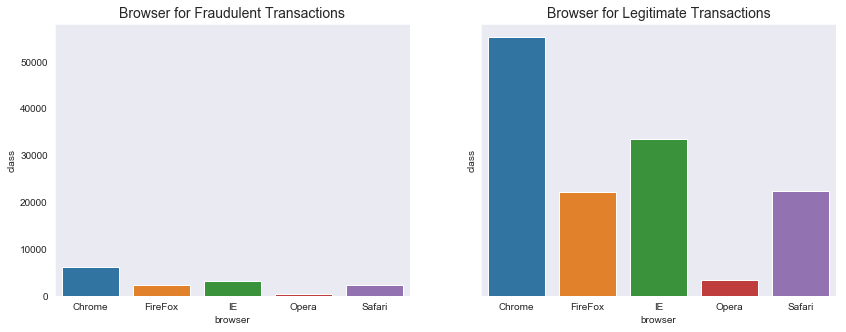

In [33]:
fraud_no_fraud_chart('browser')

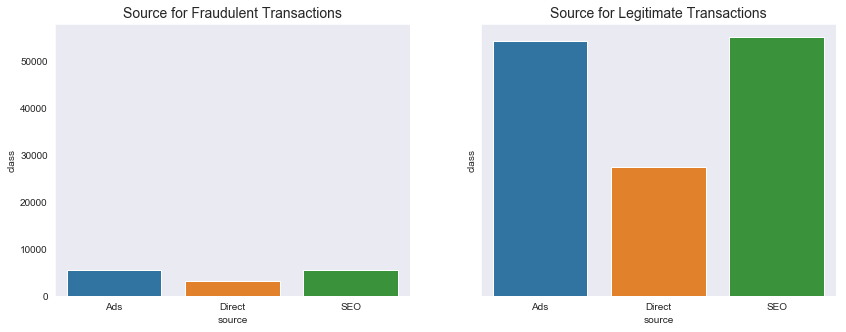

In [34]:
fraud_no_fraud_chart('source')

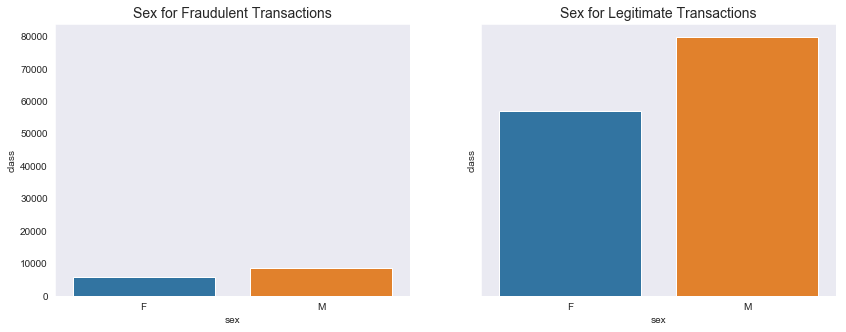

In [35]:
fraud_no_fraud_chart('sex')

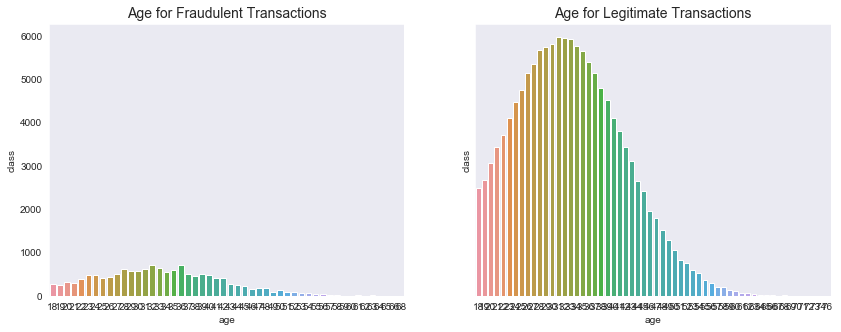

In [36]:
fraud_no_fraud_chart('age')

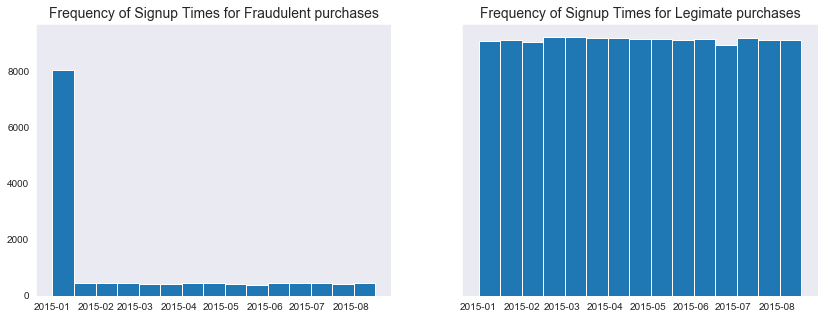

In [37]:
fig, ax = plt.subplots(1,2, figsize = (14,5),sharey=True)
ax[0].hist(fraud['signup_time'][fraud['class']==1],bins=15)
ax[0].set_title("Frequency of Signup Times for Fraudulent purchases",fontsize=14)
ax[1].hist(fraud['signup_time'][fraud['class']==0],bins=15)
ax[1].set_title("Frequency of Signup Times for Legimate purchases",fontsize=14);


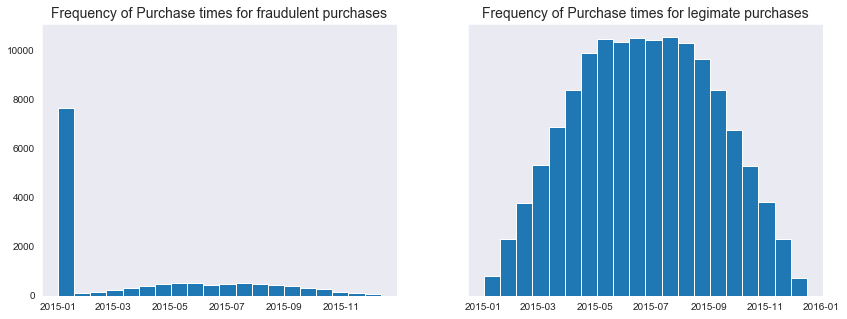

In [38]:
fig, ax = plt.subplots(1,2, figsize = (14,5),sharey=True)
ax[0].hist(fraud['purchase_time'][fraud['class']==1],bins=20)
ax[0].set_title("Frequency of Purchase times for fraudulent purchases",fontsize=14)
ax[1].hist(fraud['purchase_time'][fraud['class']==0],bins=20)
ax[1].set_title("Frequency of Purchase times for legimate purchases",fontsize=14);

**Countries:**

In [42]:
#Make sure data with countries mapped on is loaded before running this
fraud['country'].isna().sum()

21966

In [43]:
len(fraud['country'].sort_values().unique())

182

Observe Relationship between Country and Fraudulent Transactions:

In [44]:
#Total Transactions 
totals_by_country = fraud[['country','class']].groupby('country').count().sort_values('class',ascending=False)
#tota_by_country

#Fraudulent Transactions by country
fraud_by_country = fraud[['country','class']][fraud['class']==1].groupby('country').count().sort_values('class',ascending=False)
fraud_by_country.reset_index(inplace=True)

rate_df = pd.DataFrame(totals_by_country)
rate_df.reset_index(inplace=True)
rate_df2 = rate_df.merge(fraud_by_country,on='country')
rate_df2['ratio'] = rate_df2['class_y']/rate_df2['class_x']
rate_df2.rename(columns={'class_x':'total_transactions','class_y':'total_fraudulent'},inplace=True)


In [45]:
#Countries sorted by ratio of fraudulent transactions 
rate_df3 = rate_df2[rate_df2['ratio']>=.10].sort_values('ratio',ascending=False)
rate_df3

,country,total_transactions,total_fraudulent,ratio
108,Turkmenistan,1,1,1.000000
90,Namibia,23,10,0.434783
83,Sri Lanka,31,13,0.419355
70,Luxembourg,72,28,0.388889
107,Virgin Islands (U.S.),3,1,0.333333
58,Ecuador,106,28,0.264151
56,Tunisia,118,31,0.262712
55,Peru,119,31,0.260504
75,Bolivia,53,13,0.245283
64,Kuwait,90,21,0.233333


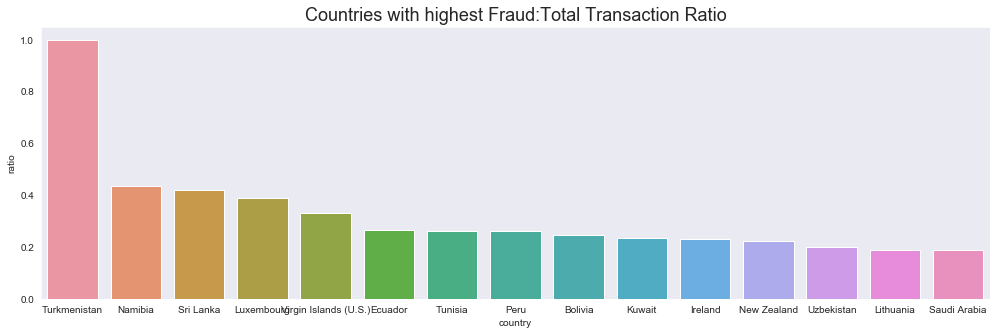

In [46]:
plt.figure(figsize=(17,5))
ax = sns.barplot(rate_df3['country'].head(15),rate_df3['ratio'].head(15))
ax.set_title("Countries with highest Fraud:Total Transaction Ratio",fontsize=18);

In [47]:
#Countries sorted by count of fraudulent transactions
rate_df4 = rate_df2.sort_values('total_fraudulent',ascending=False).head(20)
rate_df4

,country,total_transactions,total_fraudulent,ratio
0,United States,58049,5551,0.095626
1,China,12038,1043,0.086642
2,Japan,7306,715,0.097865
3,United Kingdom,4490,477,0.106236
4,Korea Republic of,4162,380,0.091302
7,Canada,2975,348,0.116975
6,France,3161,300,0.094907
8,Brazil,2961,270,0.091185
5,Germany,3646,262,0.071860
9,Italy,1944,166,0.085391


Text(0.5, 1.0, 'Countries with highest Fraud:Total Transaction Count')

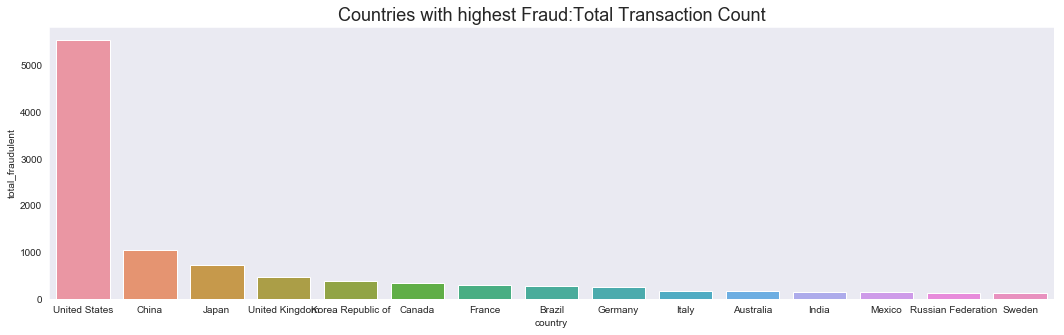

In [48]:
plt.figure(figsize=(18,5))
ax = sns.barplot(rate_df4['country'].head(15),rate_df4['total_fraudulent'].head(15))
ax.set_title("Countries with highest Fraud:Total Transaction Count",fontsize=18)

[Back to Table of Contents](#Table-of-Contents)

### Step 2: Data Transformation
To prepare data for modeling:
- convert categorical features into numeric values
- replace NaNs with 0, and
- Undersample majority class to balance classes


**Load country tagged data**

In [41]:
fraud=pd.read_csv('../data/fraud_w_country.csv')
fraud.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


**Ordinalize Categorical features**

In [49]:
#Ordinalize Source
source_dict = {'SEO':0, 'Ads':1, 'Direct':2}
fraud.source = fraud.source.replace(source_dict)

#Ordinalize Browser
browser_dict = {'Chrome':0, 'Opera':1, 'Safari':2, 'IE':3, 'FireFox':4}
fraud.browser =fraud.browser.replace(browser_dict)

#Binarize Sex
fraud['sex']=[1 if i == 'M' else 0 for i in fraud['sex']]

In [50]:
fraud2 = fraud.copy()

In [51]:
fraud2.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,0,0,1,39,7.327584e+08,0,Japan
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,1,0,0,53,3.503114e+08,0,United States
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,0,1,1,53,2.621474e+09,1,United States
3,3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,0,2,1,41,3.840542e+09,0,NaN
4,4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,1,2,1,45,4.155831e+08,0,United States


In [52]:
labels = fraud2['country'].astype('category').cat.categories.tolist()
replace_map = {'country' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
#replace_map

In [53]:
#replace country names with numerical values
fraud2.replace(replace_map,inplace=True)
#Fill NaNs with zero
fraud2['country'].fillna(0,inplace=True)

In [54]:
fraud2.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,0,0,1,39,7.327584e+08,0,85.0
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,1,0,0,53,3.503114e+08,0,172.0
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,0,1,1,53,2.621474e+09,1,172.0
3,3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,0,2,1,41,3.840542e+09,0,0.0
4,4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,1,2,1,45,4.155831e+08,0,172.0


[Back to Table of Contents](#Table-of-Contents)

**Undersample majority class to balance classes**

In [55]:
from random import random 

In [97]:
no_frauds = len(fraud2[fraud2['class'] == 1])
no_fraud_indices = fraud2[fraud2['class'] == 0].index

random_indices = np.random.choice(no_fraud_indices,no_frauds, replace=False)
fraud_indices = fraud2[fraud2['class'] == 1].index

under_sample_indices = np.concatenate([fraud_indices,random_indices])
under_sample = fraud2.loc[under_sample_indices]


In [57]:
under_sample.shape

(28302, 13)

In [58]:
under_sample.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,0,1,1,53,2.621474e+09,1,172.0
24,24,171711,2015-01-11 01:51:15,2015-01-11 01:51:16,52,YPLQGKBAAULUV,2,3,0,35,1.120619e+09,1,172.0
25,25,59780,2015-01-04 22:32:33,2015-01-16 01:13:43,31,WUMOBGUCBOXPO,0,4,1,36,1.752167e+09,1,172.0
29,29,151705,2015-01-07 03:44:53,2015-01-07 03:44:54,48,URHCRIXOMLJMH,0,0,0,27,2.836025e+09,1,172.0
59,59,345865,2015-02-01 05:59:23,2015-02-20 08:09:10,36,FKQPZUELCRKBL,0,3,1,30,2.740590e+09,1,61.0


In [59]:
under_sample['class'].value_counts()

1    14151
0    14151
Name: class, dtype: int64

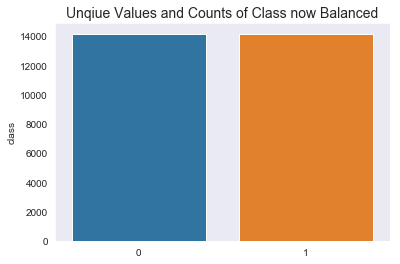

In [60]:
plt.figure(figsize=(6,4))
ax = sns.barplot(under_sample['class'].unique(),under_sample['class'].value_counts())
ax.set_title("Unqiue Values and Counts of Class now Balanced",fontsize=14);

### Step 3: Modeling
Classification models to explore:

1. RandomForest Classifier <br>
2. KNN
3. AdaBoost
4. Naive Bayes
5. Bagged Decision Tree

In [61]:
fraud2._get_numeric_data().head()

,Unnamed: 0,user_id,purchase_value,source,browser,sex,age,ip_address,class,country
0,0,22058,34,0,0,1,39,7.327584e+08,0,85.0
1,1,333320,16,1,0,0,53,3.503114e+08,0,172.0
2,2,1359,15,0,1,1,53,2.621474e+09,1,172.0
3,3,150084,44,0,2,1,41,3.840542e+09,0,0.0
4,4,221365,39,1,2,1,45,4.155831e+08,0,172.0


In [62]:
#Excluded ip address because country is a more informative feature (more than one ip address maps to each country)
features = ['user_id',
           'purchase_value',
           'source', 
           'browser',
           'sex', 
           'age', 
           'country']

In [63]:
X =under_sample[features]
y=under_sample['class']

In [64]:
#X= fraud2[features]
#y=fraud2['class']

In [65]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,stratify=y)

1. RandomForest Classifier

In [66]:
#Baseline scores and RF defaults 
rf = RandomForestClassifier(n_estimators=10) 
rf.fit(X_train,y_train)
rf_preds= rf.predict(X_test)
print("RF with default estimators and max_depth")
print("Precision:",precision_score(y_test,rf_preds))
print("Recall",recall_score(y_test,rf_preds))
print("Fl-Score",f1_score(y_test,rf_preds));

RF with default estimators and max_depth
Precision: 0.6892430278884463
Recall 0.5927194860813705
Fl-Score 0.6373474556758002


In [67]:
#Manual Tuning of RF 
for i in [50,100,150]:
    for j in [20,30]:
        for k in [2,5]:
            rf = RandomForestClassifier(n_estimators=i,max_depth=j,min_samples_split=k)
            rf.fit(X_train,y_train)
            rf_preds= rf.predict(X_test)

            print("RF with "+str(i) +" estimators", " and max_depth of "+ str(j)+" and min_sample_split "+str(k))
            print("Precision:",precision_score(y_test,rf_preds))
            print("Recall",recall_score(y_test,rf_preds))
            print("Fl-Score",f1_score(y_test,rf_preds))
            print("")

RF with 50 estimators  and max_depth of 20 and min_sample_split 2
Precision: 0.6747149564050973
Recall 0.6462526766595289
Fl-Score 0.6601771847314887

RF with 50 estimators  and max_depth of 20 and min_sample_split 5
Precision: 0.6851291598789854
Recall 0.630406852248394
Fl-Score 0.6566298650607785

RF with 50 estimators  and max_depth of 30 and min_sample_split 2
Precision: 0.6832183908045977
Recall 0.6364025695931478
Fl-Score 0.6589800443458981

RF with 50 estimators  and max_depth of 30 and min_sample_split 5
Precision: 0.6811794517392306
Recall 0.6331905781584583
Fl-Score 0.6563089557207857

RF with 100 estimators  and max_depth of 20 and min_sample_split 2
Precision: 0.6842345425507643
Recall 0.6421841541755888
Fl-Score 0.6625428034905556

RF with 100 estimators  and max_depth of 20 and min_sample_split 5
Precision: 0.6876883839554834
Recall 0.635117773019272
Fl-Score 0.6603584548591784

RF with 100 estimators  and max_depth of 30 and min_sample_split 2
Precision: 0.69032850907420

Best hyperparameters: 
    - n_estimators: 100
    - max_depth: 30
    - min_samples_split: 5

Implement best params for RandomForest:

In [99]:
rf = RandomForestClassifier(n_estimators=100,max_depth=30,min_samples_split=5) 
rf.fit(X_train,y_train)
rf_preds= rf.predict(X_test)
print("RF with 100 estimators, max_depth=30, min_sample_split=5")
print("Precision:",precision_score(y_test,rf_preds))
print("Recall",recall_score(y_test,rf_preds))
print("Fl-Score",f1_score(y_test,rf_preds));

RF with 100 estimators, max_depth=30, min_sample_split=5
Precision: 0.6939940625713633
Recall 0.6507494646680942
Fl-Score 0.6716764283346226


2. KNN

This model is not the best at scale (as is RandomForest) but we observe the results to see if its a better model on the current data. 

In [69]:
from sklearn.preprocessing import StandardScaler

In [70]:
#try scaling data first?
ss=StandardScaler()
X_train_sc= ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)
#Baseline with faults on undersampled data: 
knn = KNeighborsClassifier()
knn.fit(X_train_sc,y_train)
knn_preds = knn.predict(X_test_sc)
print("Precision:",precision_score(y_test,knn_preds))
print("Recall",recall_score(y_test,knn_preds))
print("Fl-Score",f1_score(y_test,knn_preds))

/Users/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


Precision: 0.5844864548820893
Recall 0.6421841541755888
Fl-Score 0.6119783695541272


Gridsearch for best KNN Params

In [71]:
knn_params = {
    'n_neighbors':[1,3,5,7,9,15],
    'weights':['uniform','distance'],
    'metric': ['euclidean', 'manhattan']
}

In [72]:
knn_gridsearcher = GridSearchCV(KNeighborsClassifier(), knn_params, verbose=1)
knn_gridsearcher.fit(X_train_sc, y_train)

/Users/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.3min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9, 15], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [74]:
knn_gridsearcher.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

Implement best params

In [75]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance',metric='manhattan')
knn.fit(X_train_sc,y_train)
knn_preds = knn.predict(X_test_sc)

With scaling:

In [76]:
print("Precision:",precision_score(y_test,knn_preds))
print("Recall",recall_score(y_test,knn_preds))
print("Fl-Score",f1_score(y_test,knn_preds))

Precision: 0.6032920288514888
Recall 0.6985010706638116
Fl-Score 0.6474149052297311


3. AdaBoost

In [77]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
ada.fit(X_train,y_train)
ada_preds = ada.predict(X_test)
print("Precision:",precision_score(y_test,ada_preds))
print("Recall",recall_score(y_test,ada_preds))
print("Fl-Score",f1_score(y_test,ada_preds))

Precision: 0.6016477857878476
Recall 0.6254817987152034
Fl-Score 0.6133333333333334


In [78]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

In [79]:
ada_params = {
    'n_estimators': [100,150,200],
    'base_estimator__max_depth': [1,2],
    'learning_rate': [.9, 1.]
}


In [80]:
gs_ada = GridSearchCV(ada, param_grid=ada_params, cv=3)
gs_ada.fit(X_train, y_train)
print(gs_ada.best_score_)

0.5415567978061386


In [81]:
gs_ada.best_params_

{'base_estimator__max_depth': 2, 'learning_rate': 1.0, 'n_estimators': 200}

Implement best params

In [82]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                        learning_rate= 1,
                        n_estimators=200)
ada.fit(X_train,y_train)
ada_pred = ada.predict(X_test)

In [83]:
print("Precision:",precision_score(y_test,ada_preds))
print("Recall",recall_score(y_test,ada_preds))
print("Fl-Score",f1_score(y_test,ada_preds))

Precision: 0.6016477857878476
Recall 0.6254817987152034
Fl-Score 0.6133333333333334


4. Try Multinomial Naive Bayes:

In [89]:
nb = BernoulliNB()
nb.fit(X_train,y_train)
nb_preds = nb.predict(X_test)

In [91]:
print("Bernoulli Naive Bayes with")
print("Precision:",precision_score(y_test,nb_preds))
print("Recall",recall_score(y_test,nb_preds))
print("Fl-Score",f1_score(y_test,nb_preds))

Bernoulli Naive Bayes with
Precision: 0.5238706915007493
Recall 0.523982869379015
Fl-Score 0.5239267744352852


These are pretty bad - what are ways to improve it?

5. Bagged Decision Tree

In [164]:
#X=under_sample[features]
#y=under_sample['class']

In [92]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,stratify=y)

In [93]:
predictions = pd.DataFrame(index=X_test.index)
for i in range(1,11):
    X_sample = X_train.sample(n=X_train.shape[0], replace=True)
    y_sample = y_train[X_sample.index]
    t = DecisionTreeClassifier()
    t.fit(X_sample, y_sample)
    predictions['Tree {}'.format(i)] = t.predict(X_test)
predictions.head()


,Tree 1,Tree 2,Tree 3,Tree 4,Tree 5,Tree 6,Tree 7,Tree 8,Tree 9,Tree 10
118816,1,0,1,1,1,0,1,0,0,0
84979,1,1,0,0,0,0,0,0,1,0
57751,1,1,1,1,1,1,1,1,0,1
134991,0,0,0,0,0,0,1,0,0,0
120643,0,0,0,0,1,0,1,0,1,0


In [94]:
probs = predictions.mean(axis=1)
bc_preds = (probs>=0.5)

In [95]:
print("Bagged Decision Tree with under_sampled data")
print("Precision:",precision_score(y_test,bc_preds))
print("Recall",recall_score(y_test,bc_preds))
print("Fl-Score",f1_score(y_test,bc_preds))

Bagged Decision Tree with under_sampled data
Precision: 0.5887850467289719
Recall 0.7014989293361884
Fl-Score 0.6402188782489739


Recall score was higher, but precision and f1-score lower.

[Back to Table of Contents](#Table-of-Contents)

### Step 4: Model Evaluation

The best model I have implemented was the RandomForest Classifier:

In [100]:
rf = RandomForestClassifier(n_estimators=100,max_depth=30,min_samples_split=5) 
rf.fit(X_train,y_train)
rf_preds= rf.predict(X_test)
print("RF with 100 estimators, max_depth=30, min_sample_split=5")
print("Precision:",precision_score(y_test,rf_preds))
print("Recall",recall_score(y_test,rf_preds))
print("Fl-Score",f1_score(y_test,rf_preds));

RF with 100 estimators, max_depth=30, min_sample_split=5
Precision: 0.6900385749943272
Recall 0.6511777301927195
Fl-Score 0.6700451691087363


The model must be evaluated on to minimize False Negatives:

**Precision (TP/ (TP + FP)) and Recall ( TP/(TP+FN))**<Br>
**F-measures gives equal importance to precision and recall**

In [101]:
def gen_cmat(model,X_text,y_test):
    y_preds=model.predict(X_test)
    cmat = confusion_matrix(y_test,y_preds)
    #confusion matric df
    cmat_df = pd.DataFrame(cmat, columns=['Pred No-Fraud','Pred Fraud'],
                           index = ['Actual No-Fraud','Actual Fraud'])
    return cmat_df

RandomForest Confusion Matrix:

In [102]:
gen_cmat(rf,X_test,y_test)

,Pred No-Fraud,Pred Fraud
Actual No-Fraud,3304,1366
Actual Fraud,1629,3041


KNN Confusion Matrix

In [103]:
gen_cmat(knn,X_test,y_test)

,Pred No-Fraud,Pred Fraud
Actual No-Fraud,1111,3559
Actual Fraud,1211,3459


AdaBoost Confusion Matrix

In [104]:
gen_cmat(ada,X_test,y_test)

,Pred No-Fraud,Pred Fraud
Actual No-Fraud,2810,1860
Actual Fraud,1873,2797


In [105]:
cmat = confusion_matrix(y_test,bc_preds)
#confusion matric df
cmat_df = pd.DataFrame(cmat, columns=['Pred No-Fraud','Pred Fraud'],
                           index = ['Actual No-Fraud','Actual Fraud'])
cmat_df

,Pred No-Fraud,Pred Fraud
Actual No-Fraud,2382,2288
Actual Fraud,1394,3276


In [106]:
def get_metrics(model,X_test,y_test):
    y_preds=model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
    prec = tp/(tp+fp)
    rec = tp/(tp+fn)
    return ("Precision:"+str(prec) +", Recall:"+str(rec))

In [107]:
get_metrics(rf,X_test,y_test)

'Precision:0.6900385749943272, Recall:0.6511777301927195'

In [108]:
get_metrics(knn,X_test,y_test)

'Precision:0.4928754630948988, Recall:0.7406852248394005'

In [109]:
get_metrics(ada,X_test,y_test)

'Precision:0.6006012454369766, Recall:0.5989293361884368'

[Back to Table of Contents](#Table-of-Contents)

### Step 5: Next Steps

My next steps would be to refine the model with additional tuning of my current models, additional validation testing, or trying some other models such as Support Vector Classifier and other techniques to balance the classes or compensate for them;<br>
I would also do more times-series analysis, including evaluating stationary (whether the mean is constant over time) as this may be a feature that can improve the accuracy of my model.